In [11]:
from typing import List, Tuple, Iterable

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import scipy
import qiskit
from qiskit import opflow
from qiskit.opflow.primitive_ops import PauliSumOp

In [20]:
def ising_hamiltonian(pauli_list: List[Tuple[str, float]]) -> PauliSumOp:
    return PauliSumOp.from_list(pauli_list)

def get_thermal_state(H: PauliSumOp, beta: float) -> qiskit.quantum_info.DensityMatrix:
    H = H.mul(-1 * beta) # returns -beta*H
    exp_H = scipy.linalg.expm(H.to_matrix()) # returns e^H
    partition_function = np.trace(exp_H)
    return qiskit.quantum_info.DensityMatrix(exp_H / partition_function)

-1.0 * ZZ
- 1.0 * IZ
+ 1.0 * ZI


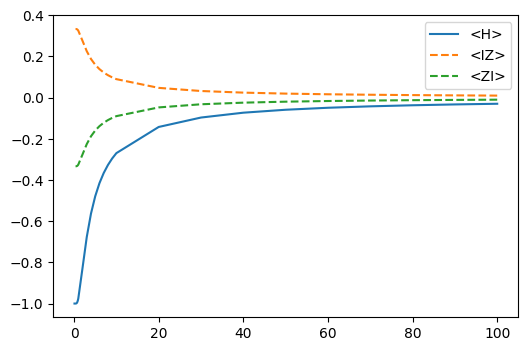

In [54]:
temp_range = list(np.arange(100, 1, -10)) + list(np.arange(9,0,-1)) + list(np.arange(0.9, 0, -0.1))

pauli_list = [('ZZ', -1), ('IZ', -1), ('ZI', 1)]
H = ising_hamiltonian(pauli_list)
print(H)
energy = []
avg_mag = []
for t in temp_range:
    beta = 1/t    
    rho = get_thermal_state(H, beta)
    energy.append(rho.expectation_value(H).real)
    spin0 = rho.expectation_value(PauliSumOp.from_list([('IZ', 1)])).real
    spin1 = rho.expectation_value(PauliSumOp.from_list([('ZI', 1)])).real
    avg_mag.append((spin0, spin1))
    
fig, ax = plt.subplots(dpi=100)
ax.plot(temp_range, energy, label='<H>')
ax.plot(temp_range, [m[0] for m in avg_mag], ls='--', label='<IZ>')
ax.plot(temp_range, [m[1] for m in avg_mag], ls='--', label='<ZI>')
ax.legend()

In [73]:
class QuantumBoltzmannMachine:
    def __init__(self, graph: nx.Graph, visible_nodes: List[int], hidden_nodes: List[int]) -> None:
        self.graph = graph
        self.num_units = len(list(self.graph.nodes))
        
        # Check valid input
        for i, j in zip(sorted(visible_nodes + hidden_nodes), range(self.num_units)):
            if i != j:
                raise ValueError(f"The given visible: {visible_nodes} and hidden: {hidden_nodes} nodes are invalid for a BM with {self.num_units} nodes")
        if len(visible_nodes) + len(hidden_nodes) != self.num_units:
            raise ValueError(f"The given visible: {visible_nodes} and hidden: {hidden_nodes} nodes are invalid for a BM with {self.num_units} nodes")
        
        self.visible_nodes = visible_nodes
        self.hidden_nodes = hidden_nodes
        
        # Parameter initialization
        self.single_params = np.array([np.random.uniform(low=-1.0, high=1.0) for _ in range(self.num_units)])
        self.double_params = {edge: np.random.uniform(low=-1.0, high=1.0) for edge in self.graph.edges}

    
    def get_hamiltonian(self, clamped: bool = False) -> PauliSumOp:
        pauli_list = []
        
        # single terms
        for node, param in enumerate(self.single_params):
            if clamped and node in self.visible_nodes:
                continue
            pauli = ['I'] * self.num_units
            pauli[node] = 'Z'
            pauli_list.append((''.join(reversed(pauli)), -1*param))
        
        # double terms
        for edge in self.graph.edges():
            if clamped and edge[0] in self.visible_nodes and edge[1] in self.visible_nodes:
                continue
            param = self.double_params[edge]
            pauli = ['I'] * self.num_units
            pauli[edge[0]] = 'Z'
            pauli[edge[1]] = 'Z'
            pauli_list.append((''.join(reversed(pauli)), -1*param))
        
        return PauliSumOp.from_list(pauli_list)


    def get_thermal_state(H: PauliSumOp, beta: float) -> qiskit.quantum_info.DensityMatrix:
        H = H.mul(-1 * beta) # returns -beta*H
        exp_H = scipy.linalg.expm(H.to_matrix()) # returns e^H
        partition_function = np.trace(exp_H)
        return qiskit.quantum_info.DensityMatrix(exp_H / partition_function)


    def exact_optimization(self, data_dist: dict, step_size: float = 0.1, cutoff: float = 1e-3,
                           max_epoch: int = 100, verbose: int = 0, beta: float = 10.0) -> None:
        cur_epoch = 1
        progress = 100
        while progress > cutoff and cur_epoch <= max_epoch:
            # Get clamped and unclamped Hamiltonians
            unclamped_hamiltonian = self.get_hamiltonian(clamped=False)
            clamped_hamiltonian   = self.get_hamiltonian(clamped=True)
            
            # Get their respective low-temperature thermal states
            unclamped_rho = self.get_thermal_state(unclamped_hamiltonian, beta)
            clamped_rho = self.get_thermal_state(clamped_hamiltonian, beta)
            
            # Update parameters, Theta(n) -> Theta(n+1)
            

[0, 1] [2]
[-0.0370276  -0.98955041 -0.20774664]
{(0, 1): -0.6836169242200705, (0, 2): -0.3662454894256406, (1, 2): 0.4125514383916917}
0.20774664100873697 * ZII
+ 0.3662454894256406 * ZIZ
- 0.4125514383916917 * ZZI


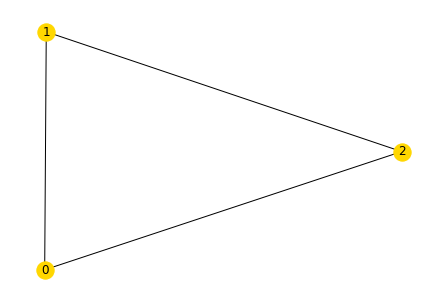

In [74]:
#G = nx.generators.classic.complete_graph(7)
G = nx.Graph()
G.add_edges_from([(0,1), (0,2), (1,2)])#, (0,4), (0,5), (0,6),
                  #(1,3), (1,4), (1,5), (1,6),
                  #(2,3), (2,4), (2,5), (2,6),])
nx.draw_spring(G, with_labels=True, node_color='gold')

visible = [0,1]
hidden = [2]
bm = QuantumBoltzmannMachine(G, visible, hidden)
print(bm.visible_nodes, bm.hidden_nodes)
print(bm.single_params)
print(bm.double_params)
print(bm.get_hamiltonian(clamped=True))